A1. Write a function to calculate the entropy associated with your dataset. (If your dataset contains only continuous numeric data for outcome (a regression problem), employ equal width binning and divide your data into 4 bins. Each bin may be considered as a categorical data value. Write a function
for equal width binning) Here, pi refers to the probability of occurrence of each outcome value.

In [32]:
import pandas as pd
import math
from collections import Counter

# Function for Entropy Calculation with Binning
def entropy_with_binning(data, bins=4):
    binned_data = pd.cut(data, bins, labels=False)
    probabilities = [count / len(data) for count in Counter(binned_data).values()]
    return -sum(p * math.log2(p) for p in probabilities if p > 0)

# Main Execution
df = pd.read_excel("student_embeddings.xlsx")
print("Entropy of dataset:", entropy_with_binning(df[df.columns[-1]]))


Entropy of dataset: 1.8293521368699557


A2. Calculate the Gini index value for your dataset.

In [33]:
import pandas as pd
from collections import Counter

# Function to calculate Gini Index with binning
def gini_with_binning(data, bins=4):
    binned_data = pd.cut(data, bins, labels=False)
    probabilities = [count / len(data) for count in Counter(binned_data).values()]
    return 1 - sum(p ** 2 for p in probabilities)

# Main Execution
df = pd.read_excel("student_embeddings.xlsx")
print("Gini Index of dataset:", gini_with_binning(df[df.columns[-1]]))


Gini Index of dataset: 0.6913265306122449


A3. Write your own module for detecting the feature / attribute for the root note of a Decision Tree. Use Information gain as the impurity measure for identifying the root node. Assume that the features are categorical or could be converted to categorical by binning.  

In [71]:
import pandas as pd
import numpy as np

# Entropy & Information Gain Calculation
def entropy(col):  
    probs = col.value_counts(normalize=True)
    return -sum(probs * np.log2(probs + 1e-9))  

def info_gain(df, feature, target):
    return entropy(df[target]) - sum((df[feature] == v).mean() * entropy(df[df[feature] == v][target]) for v in df[feature].unique())

# Load & Preprocess Data
df = pd.read_excel("student_embeddings.xlsx").fillna(method="ffill")
df.columns = [f"F_{i}" for i in range(df.shape[1] - 1)] + ["Target"]
df.iloc[:, :-1] = df.iloc[:, :-1].apply(lambda x: pd.qcut(x.rank(), q=4, labels=False))

# Get Best Root Node
root = max(df.columns[:-1], key=lambda col: info_gain(df, col, "Target"))
print(f"Best Root Node: {root} (IG: {info_gain(df, root, 'Target'):.4f})")


C:\Users\vinee\AppData\Local\Temp\ipykernel_20920\2771757102.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.read_excel("student_embeddings.xlsx").fillna(method="ffill")


Best Root Node: F_0 (IG: 2.0000)


A4. If the feature is continuous valued for A3, use equal width or frequency binning for converting the attribute to categorical valued. The binning type should be a parameter to the function built for binning. Write your own function for the binning task. The number of bins to be created should also 
be passed as a parameter to the function. Use function overloading to allow for usage of default parameters if no parameters are passed.

In [74]:
import pandas as pd
import numpy as np

# Entropy calculation
def entropy(data):
    probs = data.value_counts(normalize=True)
    return -sum(probs * np.log2(probs + 1e-9))  # Avoid log(0)

# Information Gain
def info_gain(df, feature, target):
    return entropy(df[target]) - sum((df[feature] == v).mean() * entropy(df[df[feature] == v][target]) for v in df[feature].unique())

# Find best root node
def best_root(df, target):
    gains = {col: info_gain(df, col, target) for col in df.columns[:-1]}
    return max(gains, key=gains.get), max(gains.values())

# Binning function
def bin_features(df, bins=4, method="equal-frequency"):
    for col in df.columns[:-1]:
        df[col] = pd.cut(df[col], bins, labels=False) if method == "equal-width" else pd.qcut(df[col].rank(method="first"), bins, labels=False, duplicates="drop")
    return df

# Load and preprocess data
df = pd.read_excel("student_embeddings.xlsx").fillna(method='ffill')
df.columns = [f"F_{i}" for i in range(df.shape[1] - 1)] + ["Target"]
df = bin_features(df)  # Default: 4 bins, equal-frequency

# Get Best Root Node & IG
root_feature, max_ig = best_root(df, "Target")
print(f"Best Root Node Feature: {root_feature} (Information Gain: {max_ig:.4f})")


C:\Users\vinee\AppData\Local\Temp\ipykernel_20920\3277281943.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.read_excel("student_embeddings.xlsx").fillna(method='ffill')


Best Root Node Feature: F_0 (Information Gain: 2.0000)


A5. Expand the above functions to built your own Decision Tree module. 

In [78]:
import pandas as pd
import numpy as np
from collections import Counter

# Function to calculate entropy
def entropy(data):
    probs = data.value_counts(normalize=True)
    return -sum(probs * np.log2(probs))

# Function to calculate Information Gain
def info_gain(df, feature, target):
    total_entropy = entropy(df[target])
    values = df[feature].unique()
    return total_entropy - sum((df[feature] == v).mean() * entropy(df[df[feature] == v][target]) for v in values)

# Function to find best split
def best_split(df, target):
    return max(df.columns[:-1], key=lambda col: info_gain(df, col, target))

# Function to build Decision Tree
def build_tree(df, target, depth=0, max_depth=None):
    if len(df[target].unique()) == 1 or (max_depth and depth >= max_depth):
        return df[target].mode()[0]
    
    root = best_split(df, target)
    tree = {root: {}}
    
    for v in df[root].unique():
        tree[root][v] = build_tree(df[df[root] == v], target, depth + 1, max_depth)
    
    return tree

# Function to predict a single sample
def predict_sample(tree, sample):
    while isinstance(tree, dict):
        feature = next(iter(tree))
        tree = tree[feature].get(sample.get(feature), Counter(df["Target"]).most_common(1)[0][0])
    return tree

# Function to predict for all samples
def predict(df, tree):
    return np.array([predict_sample(tree, row) for _, row in df.iterrows()])

# Load dataset & preprocess
df = pd.read_excel("student_embeddings.xlsx").fillna(method='ffill')
df.columns = [f"F_{i}" for i in range(df.shape[1] - 1)] + ["Target"]
df.iloc[:, :-1] = df.iloc[:, :-1].apply(lambda x: pd.qcut(x.rank(method="first"), q=4, labels=False))

# Build Decision Tree & Predict
tree = build_tree(df, "Target", max_depth=3)
predictions = predict(df, tree)

print("Decision Tree:", tree)
print("Predictions:", predictions)


C:\Users\vinee\AppData\Local\Temp\ipykernel_20920\4002818375.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.read_excel("student_embeddings.xlsx").fillna(method='ffill')


Decision Tree: {'F_0': {3: {'F_1': {0.0: {'F_2': {0.0: -0.2406063228845596, 3.0: -0.2497797012329102}}, 3.0: {'F_2': {2.0: 0.03333140537142754, 0.0: 0.3377057611942291}}, 2.0: {'F_2': {0.0: 0.1678915172815323, 2.0: 0.1764781773090363}}, 1.0: -0.1501116007566452}}, 0: {'F_6': {0.0: 0.4582418501377106, 2.0: {'F_1': {2.0: 0.1640595048666, 0.0: -0.1459948122501373}}, 1.0: {'F_1': {0.0: 0.03334040194749832, 1.0: -0.041596919298172}}, 3.0: {'F_2': {2.0: -0.08384843915700912, 3.0: 0.1340561658143997}}}}, 1: {'F_1': {3.0: {'F_2': {2.0: -0.03148850053548813, 1.0: 0.313873678445816}}, 0.0: 0.005323436111211777, 1.0: {'F_2': {0.0: 0.2361329644918442, 1.0: -0.06449776887893677}}, 2.0: {'F_2': {1.0: -0.03991277515888214, 3.0: 0.06062730774283409}}}}, 2: {'F_2': {1.0: {'F_1': {2.0: 0.01389139331877232, 1.0: 0.02571270987391472}}, 0.0: {'F_1': {2.0: 0.188266322016716, 1.0: 0.2394997775554657}}, 2.0: {'F_3': {1.0: 0.1584229916334152, 3.0: 0.0537189394235611}}, 3.0: 0.008908607997000217}}}}
Predictions

A6. Draw and visualize the decision tree constructed based on your data. (Refer above provided web sources [1] & [2] for understanding and learning on how to visualize a DT). 

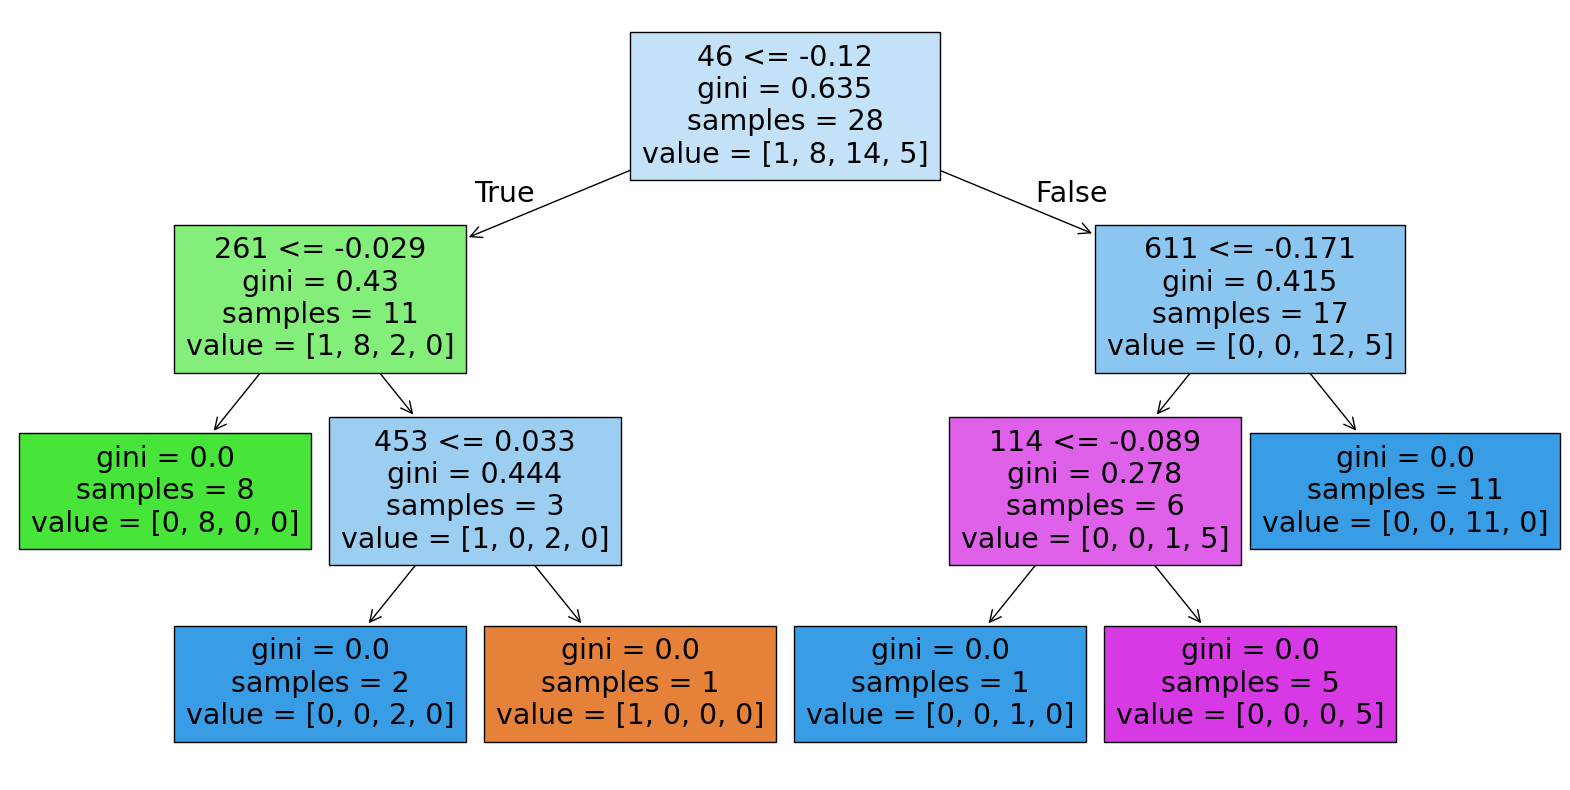

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder

# Function for Equal Width Binning
def equal_width_binning(data, num_bins=3):
    if data.isna().sum() > 0:  # Handle missing values
        data = data.fillna(data.median())  
    bins = np.linspace(data.min(), data.max(), num_bins + 1)
    return np.digitize(data, bins, right=True) - 1

# Main function
def main():
    df = pd.read_excel('student_embeddings.xlsx')  # Ensure file is correct
    df = df.dropna()  # Drop rows with missing values
    
    X = df.iloc[:, :-1].apply(pd.to_numeric, errors='coerce').fillna(0).values  # Convert to numeric
    y = equal_width_binning(df.iloc[:, -1])  # Target (last column)

    # Ensure y is numerical
    if y.dtype == 'O':
        y = LabelEncoder().fit_transform(y)

    tree = DecisionTreeClassifier(max_depth=3, random_state=42)
    tree.fit(X, y)

    plt.figure(figsize=(20, 10))
    plot_tree(tree, filled=True, feature_names=df.columns[:-1])
    plt.show()

main()


A7. Use 2 features from your dataset for a classification problem. Visualize the decision boundary created by your DT in the vector space. (Refer above provided web source [3] & [2] for understanding and learning on how to draw decision boundary for a DT). 

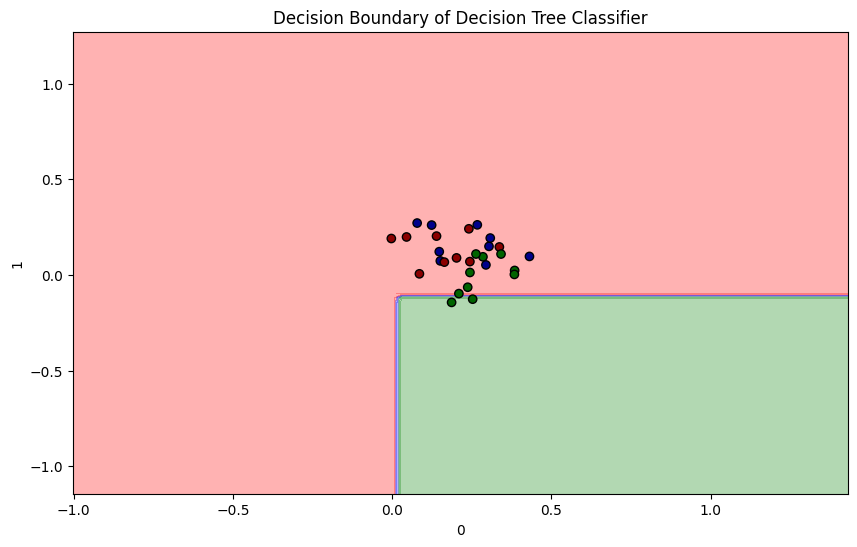

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap

# Load dataset
df = pd.read_excel('student_embeddings.xlsx')

# Select two features and the target
feature1, feature2 = df.columns[1], df.columns[2]  # Modify if needed
X = df[[feature1, feature2]].values
y = df.iloc[:, -1]  # Assuming last column is the target

# Encode target if categorical
y = LabelEncoder().fit_transform(y.astype(str))

# Train Decision Tree classifier
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X, y)

# Plot decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

Z = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(["red", "blue", "green"]))
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=ListedColormap(["darkred", "darkblue", "darkgreen"]))
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Decision Boundary of Decision Tree Classifier")
plt.show()
